# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

# rla IJ mask and roi functions
import ij_mask_roi

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# SET IMAGE SIZE
IMAGE_SIZE = 2048

# SET IMAGE DIRECTORIES
IMAGE_TRAIN_DIR = os.path.join(ROOT_DIR, 'rla/images/2048/train/')
IMAGE_VAL_DIR = os.path.join(ROOT_DIR, 'rla/images/2048/verify/')

In [3]:
#setup slack notifications:
from slacker import Slacker
from secret.keys import slack_api_key
slack = Slacker(slack_api_key)
def send_slack(message):
    slack.chat.post_message('#notify-richard', message)

In [4]:
for root, dirs, files in os.walk(ROOT_DIR):
    print(dirs)
    break
    

['.git', 'assets', 'secret', 'rla', 'logs', '.ipynb_checkpoints', 'samples', 'images', '__pycache__']


## Configurations

In [5]:
class imgConfig(Config):
    """Configuration for training.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cells_roi"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200 #1000

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
config = imgConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[512 512]
 [256 256]
 [128 128]
 [ 64  64]
 [ 32  32]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_MIN_DIM                  2048
IMAGE_PADDING                  True
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cells_roi
NUM_CLASSES                    4
POOL_SIZE      

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
class imgDataset(utils.Dataset):
    """
    Load images from file and generate object instance masks 
    from IJ masks and roi.zip files
    """

    def add_images(self, image_dir, height, width, orig_height=None, orig_width=None):
        """
        Add image path info from directory
        INPUT:
            image_dir: Directory containing images, masks, and roi.zip files
            height: image height
            width: image width
            orig_height: if padded, store original image height here
            orig_width: if padded, store original image width here
        OUTPUT:
            NONE
            Adds image info to the Dataset class to be called later
        """
        # Add classes
        dataset_name = 'cells_roi'
        self.add_class(dataset_name, 1, "nucleus")
        self.add_class(dataset_name, 2, "nucleolus")

        # Add .tif images
        # Path of mask and ROI in image info
        files = os.listdir(image_dir)
        for i, file in enumerate(files):
            if file.endswith('.tif') and 'mask' not in file:
                img_path = os.path.join(ROOT_DIR, image_dir + file)
                mask_path = os.path.splitext(img_path)[0] + '_mask.tif'
                roi_path = os.path.splitext(img_path)[0] + '1.zip'
                # Check whether a mask and ROI exist:
                if not os.path.exists(mask_path):
                    mask_path = None
                if not os.path.exists(roi_path):
                    roi_path = None
                self.add_image(dataset_name, image_id=i, path=img_path,
                               width=width, height=height,
                               orig_width=orig_width, orig_height=orig_height,
                               mask_path=mask_path, roi_path=roi_path,
                               )
        print('{} images added.'.format(len(self.image_info)))
    
    def resize(self, image, max_dim):
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        return image
    
    def load_image(self, image_id):
        """
        Load image from image_info dictionary
        """
        info = self.image_info[image_id]
        path = info['path']
        # print(path)        #print each image to troubleshoot where failures occur
        image = ij_mask_roi.openTifImage(path)
        image = np.rollaxis(image, 0,3)
        
        return image

    def load_mask(self, image_id):
        """
        Generate instance masks using IJ masks and roi.zip for the given image ID.
        """
        info = self.image_info[image_id]
#         if info['orig_height'] is not None and info['orig_width'] is not None:
#             height = info['orig_height']
#             width = info['orig_width']
#         else:
#             height = info['height']
#             width = info['width']
        mask_arrays = mask_classes = roi_arrays = roi_classes = []
        if info['mask_path']:
            #print(info['mask_path'])
            mask_arrays, mask_classes = ij_mask_roi.getMaskObjects(info['mask_path'], 1)
        if info['roi_path']:
            #print(info['roi_path'])
            roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, info['height'], info['width'])
#             print(roi_arrays.shape)
            
        # If both Masks and ROIs exist, append them
        # Otherwise, use the non-zero array
        if len(mask_arrays) > 0 and len(roi_arrays) > 0:
            masks = np.append(mask_arrays, roi_arrays, axis=2)
            class_ids = np.append(mask_classes, roi_classes)
        elif len(mask_arrays) > 0:
            masks = mask_arrays
            class_ids = mask_classes
        elif len(mask_arrays) > 0:
            masks = roi_arrays
            class_ids = roi_classes
            
        return masks.astype(np.bool), class_ids.astype(np.int32)
#         return mask_arrays.astype(np.bool), mask_classes.astype(np.int32)

In [8]:
# Training dataset
dataset_train = imgDataset()
dataset_train.add_images(IMAGE_TRAIN_DIR, IMAGE_SIZE, IMAGE_SIZE) # 4096, 4096,
dataset_train.prepare()

# Validation dataset
dataset_val = imgDataset()
dataset_val.add_images(IMAGE_VAL_DIR, IMAGE_SIZE, IMAGE_SIZE)
dataset_val.prepare()

40 images added.
6 images added.


In [9]:
test_img = dataset_train.load_image(1)
print(type(test_img))
print(test_img.shape)

test_mask, test_cids = dataset_train.load_mask(9)
print(type(test_mask))
print(test_mask.shape)

# test_roi, test_cids = dataset_train.get_source_class_id

<class 'numpy.ndarray'>
(2048, 2048, 3)
<class 'numpy.ndarray'>
(2048, 2048, 439)


In [10]:
info = dataset_train.image_info[1]
print(info['mask_path'])
print(info['roi_path'])
roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, height=info['height'], width=info['width'])
print(roi_arrays.shape)
print(roi_classes.shape)

/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-2 cMYCsi_1002_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-2 cMYCsi_1002_processed1.zip
(2048, 2048, 17)
(17,)


In [11]:
for info in dataset_train.image_info:
    print(info['mask_path'])
    print(info['roi_path'])
    roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, height=info['height'], width=info['width'])
    print(roi_arrays.shape)
    print(roi_classes.shape)

/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 Mock_1001_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 Mock_1001_processed1.zip
(2048, 2048, 159)
(159,)
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-2 cMYCsi_1002_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-2 cMYCsi_1002_processed1.zip
(2048, 2048, 17)
(17,)
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1003_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1003_processed1.zip
(2048, 2048, 1230)
(1230,)
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 cMYCsi_1001_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 cMYCsi_1001_processed1.zip
(2048, 2048, 53)
(53,)
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi_processed_mask.tif
/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBF

/home/rla/deeplearn/Mask_RCNN/rla/images/train/10-3 Mock_1003_1_processed.tif


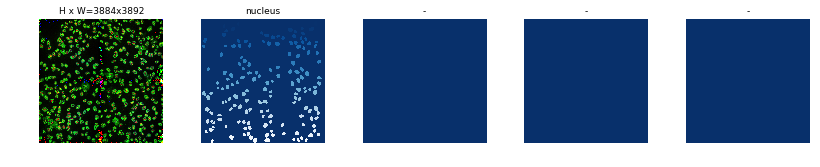

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
try:
    model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE, 
        epochs=1, 
        layers='heads')
except Exception as e:
    print(e)
    print('DONE')
    send_slack('Exception while training. Run ended prematurely.')
    raise e
send_slack('All runs complete.')
print('DONE')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/deeplearn/Mask_RCNN/logs/cells_roi20180409T2022/mask_rcnn_cells_roi_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

Instructions for updating:
keep_dims is deprecated, use keepdims instead
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages

Epoch 1/1


ERROR:root:Error processing image {'id': 83, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1192, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 64, in load_image
    image = np.rollaxis(image, 0,3)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/numeric.py", line 1447, in rollaxis
    raise AxisError(msg % ('start', -n, 'start',

  4/100 [>.............................] - ETA: 45:30 - loss: 10.5951 - rpn_class_loss: 0.1314 - rpn_bbox_loss: 1.7147 - mrcnn_class_loss: 1.0542 - mrcnn_bbox_loss: 2.1187 - mrcnn_mask_loss: 5.5760  

ERROR:root:Error processing image {'id': 78, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1193, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 85, in load_mask
    roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, info['height'], info['width'])
  File "/home/ubuntu/deeplearn/Mask_RCNN/ij_mask_roi.py", line 111, in getROIobjects
    masks

  7/100 [=>............................] - ETA: 25:49 - loss: 8.4492 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 1.4067 - mrcnn_class_loss: 0.7932 - mrcnn_bbox_loss: 1.7725 - mrcnn_mask_loss: 4.3782

ERROR:root:Error processing image {'id': 78, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1193, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 85, in load_mask
    roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, info['height'], info['width'])
  File "/home/ubuntu/deeplearn/Mask_RCNN/ij_mask_roi.py", line 111, in getROIobjects
    masks

  8/100 [=>............................] - ETA: 22:32 - loss: 8.5287 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.3471 - mrcnn_class_loss: 0.9621 - mrcnn_bbox_loss: 1.8129 - mrcnn_mask_loss: 4.3090

 21/100 [=====>........................] - ETA: 8:06 - loss: 7.4247 - rpn_class_loss: 0.4242 - rpn_bbox_loss: 1.7510 - mrcnn_class_loss: 1.1341 - mrcnn_bbox_loss: 1.7656 - mrcnn_mask_loss: 2.3499

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (50334352)
  warnings.warn('invalid page offset (%i)' % offset)


 22/100 [=====>........................] - ETA: 7:41 - loss: 7.3299 - rpn_class_loss: 0.4130 - rpn_bbox_loss: 1.7336 - mrcnn_class_loss: 1.1363 - mrcnn_bbox_loss: 1.7842 - mrcnn_mask_loss: 2.2629

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:1843: UserWarning: failed to reshape (2522460,) to (2048, 2048)
  result.shape, series.shape))
ERROR:root:Error processing image {'id': 89, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py", line 1839, in asarray
    result.shape = series.shape
ValueError: cannot reshape array of size 2522460 into shape (2048,2048)

During handling of the above exception, another exception occurred:

Traceback (most recent call 

 26/100 [======>.......................] - ETA: 6:20 - loss: 6.6796 - rpn_class_loss: 0.3554 - rpn_bbox_loss: 1.6192 - mrcnn_class_loss: 1.0664 - mrcnn_bbox_loss: 1.6682 - mrcnn_mask_loss: 1.9704

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (50334352)
  warnings.warn('invalid page offset (%i)' % offset)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:1843: UserWarning: failed to reshape (2522460,) to (2048, 2048)
  result.shape, series.shape))
ERROR:root:Error processing image {'id': 89, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images

 65/100 [==================>...........] - ETA: 2:16 - loss: 4.5906 - rpn_class_loss: 0.2367 - rpn_bbox_loss: 1.4147 - mrcnn_class_loss: 0.7562 - mrcnn_bbox_loss: 1.1286 - mrcnn_mask_loss: 1.0543

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (50334352)
  warnings.warn('invalid page offset (%i)' % offset)
ERROR:root:Error processing image {'id': 83, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.U

 73/100 [====================>.........] - ETA: 1:50 - loss: 4.3811 - rpn_class_loss: 0.2284 - rpn_bbox_loss: 1.3889 - mrcnn_class_loss: 0.7250 - mrcnn_bbox_loss: 1.0588 - mrcnn_mask_loss: 0.9800

ERROR:root:Error processing image {'id': 78, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi002_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1193, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 91, in load_mask
    masks = np.append(mask_arrays, roi_arrays, axis=2)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py", line 5166, in append
    return concate

 74/100 [=====================>........] - ETA: 1:48 - loss: 4.3288 - rpn_class_loss: 0.2256 - rpn_bbox_loss: 1.3769 - mrcnn_class_loss: 0.7152 - mrcnn_bbox_loss: 1.0445 - mrcnn_mask_loss: 0.9667

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (50334352)
  warnings.warn('invalid page offset (%i)' % offset)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:1843: UserWarning: failed to reshape (2522460,) to (2048, 2048)
  result.shape, series.shape))
ERROR:root:Error processing image {'id': 89, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-1 mock_1004_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images

 76/100 [=====================>........] - ETA: 1:39 - loss: 4.3261 - rpn_class_loss: 0.2259 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.7065 - mrcnn_bbox_loss: 1.0307 - mrcnn_mask_loss: 0.9531

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2034: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn('invalid ImageJ metadata or corrupted file')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (50334352)
  warnings.warn('invalid page offset (%i)' % offset)
ERROR:root:Error processing image {'id': 83, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/204810-3 UBFsi001_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.U

 88/100 [=========================>....] - ETA: 50s - loss: 4.1523 - rpn_class_loss: 0.2177 - rpn_bbox_loss: 1.4248 - mrcnn_class_loss: 0.6729 - mrcnn_bbox_loss: 0.9600 - mrcnn_mask_loss: 0.8769

ERROR:root:Error processing image {'id': 93, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1004_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1004_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1004_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1193, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 85, in load_mask
    roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, info['height'], info['width'])
  File "/home/ubuntu/deeplearn/Mask_RCNN/ij_mask_roi.py", line 111, in getRO

 91/100 [==========================>...] - ETA: 38s - loss: 4.0920 - rpn_class_loss: 0.2122 - rpn_bbox_loss: 1.4017 - mrcnn_class_loss: 0.6706 - mrcnn_bbox_loss: 0.9483 - mrcnn_mask_loss: 0.8592

ERROR:root:Error processing image {'id': 8, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1003_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1003_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/train/2048Parental UBFsi_1003_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1193, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-a265cdc306ba>", line 91, in load_mask
    masks = np.append(mask_arrays, roi_arrays, axis=2)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py", line 5166, in append
 

 99/100 [============================>.] - ETA: 4s - loss: 3.9324 - rpn_class_loss: 0.2047 - rpn_bbox_loss: 1.3622 - mrcnn_class_loss: 0.6406 - mrcnn_bbox_loss: 0.9047 - mrcnn_mask_loss: 0.8202

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 16, 'source': 'cells_roi', 'path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/verify/204810-4  Mock_1001_processed.tif', 'width': 2048, 'height': 2048, 'orig_width': None, 'orig_height': None, 'mask_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/verify/204810-4  Mock_1001_processed_mask.tif', 'roi_path': '/home/ubuntu/deeplearn/Mask_RCNN/rla/images/2048/verify/204810-4  Mock_1001_processed1.zip'}
Traceback (most recent call last):
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", line 1676, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/deeplearn/Mask_RCNN/model.py", lin

100/100 [==============================] - 530s 5s/step - loss: 3.9451 - rpn_class_loss: 0.2048 - rpn_bbox_loss: 1.3879 - mrcnn_class_loss: 0.6353 - mrcnn_bbox_loss: 0.9011 - mrcnn_mask_loss: 0.8161 - val_loss: 1.7618 - val_rpn_class_loss: 0.0425 - val_rpn_bbox_loss: 0.4760 - val_mrcnn_class_loss: 0.3761 - val_mrcnn_bbox_loss: 0.5301 - val_mrcnn_mask_loss: 0.3370
DONE


In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [15]:
class InferenceConfig(imgConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/deeplearn/Mask_RCNN/logs/cells_roi20180409T2022/mask_rcnn_cells_roi_0001.h5


original_image           shape: (2048, 2048, 3)       min: -103.96375  max: 6265.85205
image_meta               shape: (11,)                 min:    0.00000  max: 2048.00000
gt_class_id              shape: (15, 4)               min:  522.00000  max: 1993.00000
gt_bbox                  shape: (15, 4)               min:  522.00000  max: 1993.00000
gt_mask                  shape: (2048, 2048, 15)      min:    0.00000  max:    1.00000


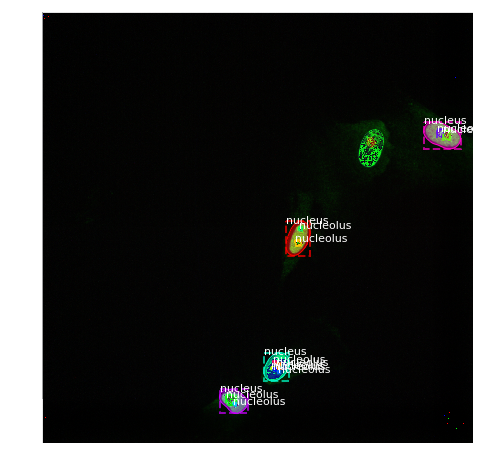

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


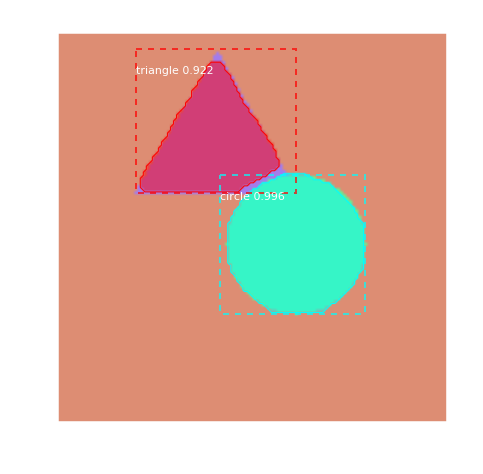

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
